In [1]:
from pathlib import Path

PHENOTYPE_FOLDER = Path("/local/scratch/carlyn.1/dna/colors/processed")
GENOME_FOLDER = Path("/local/scratch/carlyn.1/dna/vcfs/processed/genome")
DATA_SPLIT_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/data")
RESULTS_FOLDER = Path("/local/scratch/carlyn.1/dna/results/whole_genome")
PLOT_RESULTS_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/plot_results")
BATCH_SIZE = 32
DEVICE = "cuda:2"
REDO = False

ex_path = "/local/scratch/carlyn.1/dna/results/whole_genome/erato_forewings_total_chromosome_10"



In [2]:
import os
import json

import pandas as pd
import numpy as np
import torch

from scipy.stats import pearsonr
from captum.attr import GuidedGradCam

def collect_chromosome(root, species, chromosome):
    genotype_path_root = os.path.join(root, f"{species}")
    scaffolds = []
    for subdir in os.listdir(genotype_path_root):
        if species == "erato":
            chrom_info = subdir.replace("Herato", "")
            chrom_num = int(chrom_info[:2])
            scaf_num = int(chrom_info[2:])
        elif species == "melpomene":
            chrom_info = subdir.replace("Hmel2", "")
            chrom_num = int(chrom_info[:2])
            scaf_num = int(chrom_info[2:-1])
        else:
            assert False, f"Invalid species: {species}"
            
        if chrom_num == chromosome:
            scaffolds.append([subdir, scaf_num])
    scaffolds = sorted(scaffolds, key=lambda x: x[1])

    sort_verify = None
    compiled = None
    for scaffold_dir, _ in scaffolds:
        tgt_dir = os.path.join(genotype_path_root, scaffold_dir)
        camids = np.load(os.path.join(tgt_dir, "camids.npy"))
        data = np.load(os.path.join(tgt_dir, "ml_ready.npy"))
        sort_idx = np.argsort(camids)
        sorted_data = data[sort_idx].astype(np.byte)
        sorted_camids = camids[sort_idx]
        if sort_verify is not None:
            assert (sort_verify == sorted_camids).all(), "INVALID SORT"
            compiled = np.concatenate((compiled, sorted_data), axis=1)
        else:
            sort_verify = sorted_camids
            compiled = sorted_data
            
    return sort_verify, compiled

def load_data(phenotype_folder, genome_folder, split_data_folder, chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1):
    """
    NOTE: There are missing camids from either pheno or geno type data
    Seems to consistently be 1 missing from melpomene genotype
    and 4 missing from erato phenotype
    """
    pca_path = os.path.join(phenotype_folder, f"{species}_{wing}_{color}", "data.csv")
    pca_df = pd.read_csv(pca_path)
    pca_camids = pca_df.camid.to_numpy()

    sort_idx = np.argsort(pca_camids)
    pca_camids_sorted = pca_camids[sort_idx]
    
    pca_data = pca_df.iloc[:, (1 + out_dims_start_idx):(1 + out_dims_start_idx + out_dims)].to_numpy()
    pca_data = pca_data[sort_idx]
    
    sorted_camids, compiled_data = collect_chromosome(genome_folder, species, chromosome)
    conflict_camid_a = list(set.difference(set(pca_camids_sorted.tolist()), set(sorted_camids.tolist())))
    conflict_camid_b = list(set.difference(set(sorted_camids.tolist()), set(pca_camids_sorted.tolist())))
    conflict_camids = conflict_camid_a + conflict_camid_b
    
    idx = np.isin(sorted_camids, conflict_camids)
    sorted_camids = sorted_camids[~idx]
    compiled_data = compiled_data[~idx]
    
    idx = np.isin(pca_camids_sorted, conflict_camids)
    pca_camids_sorted = pca_camids_sorted[~idx]
    pca_data = pca_data[~idx]

    assert (pca_camids_sorted == sorted_camids).all(), "Invalid alignment"

    train_cams = np.load(os.path.join(split_data_folder, f"{species}_train.npy"))
    val_cams = np.load(os.path.join(split_data_folder, f"{species}_val.npy"))
    test_cams = np.load(os.path.join(split_data_folder, f"{species}_test.npy"))
    
    train_idx = np.isin(sorted_camids, train_cams)
    train_pca_data = pca_data[train_idx]
    train_geno_data = compiled_data[train_idx]
    
    val_idx = np.isin(sorted_camids, val_cams)
    val_pca_data = pca_data[val_idx]
    val_geno_data = compiled_data[val_idx]
    
    test_idx = np.isin(sorted_camids, test_cams)
    test_pca_data = pca_data[test_idx]
    test_geno_data = compiled_data[test_idx]
    
    return [train_geno_data, train_pca_data], [val_geno_data, val_pca_data], [test_geno_data, test_pca_data]

def calc_pearson_correlation(model, dloader, device, index=0):
    model.eval()
    actual = []
    predicted = []
    for i, batch in enumerate(dloader):
        model.zero_grad()
        data, pca = batch
        out = model(data.to(device))
        actual.extend(pca[:, index].detach().cpu().numpy().tolist())
        predicted.extend(out[:, index].detach().cpu().numpy().tolist())
    return pearsonr(predicted, actual)

def compile_attribution(attr):
    attr, _ = torch.abs(attr).max(-1)
    attr = attr[:, 0] # Only has 1 channel, just extract it
    attr = attr.detach().cpu().numpy()
    attr = np.median(np.abs(attr), 0) # median across batch???
    #attr = attr.sum(0) # Sum across batch...Should we be summing here???
    return attr

def get_saliency_attr(m, dloader, device, target=0):
    att_model = GuidedGradCam(m, m.last_block)
    attr_total = None
    for i, batch in enumerate(dloader):
        m.zero_grad()
        data, pca = batch
        attr = att_model.attribute(data.to(device), target=target)
        attr = compile_attribution(attr)
        if attr_total is None:
            attr_total = attr
        else:
            attr_total += attr

    #attr_total = attr_total / np.linalg.norm(attr_total, ord=1) # Normalize
    return attr_total

def load_json_attributes(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def save_json_attributes(path, data):
    with open(path, 'w') as f:
        json.dump(data, f)

In [3]:
import os

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from gtp.dataloading.datasets import GTP_Dataset
from gtp.models.net import SoyBeanNet

species = "melpomene"
wing = "forewings"
color = "color_1"
target_index = 0
chromo_results = []
chromo_pvals = []
attributions = []
num_chromosome = 21
results_dir = PLOT_RESULTS_FOLDER / f"{species}_{wing}_{color}"
os.makedirs(results_dir, exist_ok=True)

if REDO or not os.path.exists(os.path.join(results_dir, "chromosome_summary_pearson.npy")):
    for chromosome in tqdm(range(1, num_chromosome+1), "Extracting Chromosome Results"):
        train_data, val_data, test_data = load_data(PHENOTYPE_FOLDER, GENOME_FOLDER, DATA_SPLIT_FOLDER, 
                chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1)

        train_dataset = GTP_Dataset(*train_data)
        val_dataset = GTP_Dataset(*val_data)
        test_dataset = GTP_Dataset(*test_data)

        num_vcfs = train_data[0].shape[1]

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

        model = SoyBeanNet(window_size=num_vcfs, num_out_dims=1, insize=3, hidden_dim=10, drop_out_prob=0.75)
        model_path = RESULTS_FOLDER / Path(f"{species}_{wing}_{color}_chromosome_{chromosome}/model.pt")
        model.load_state_dict(torch.load(model_path))
        model = model.to(DEVICE)
        model.eval()

        with torch.no_grad():
            #tr_pearson_stat, _ = calc_pearson_correlation(model, train_dataloader, DEVICE)
            val_pearson_stat, val_pv = calc_pearson_correlation(model, val_dataloader, DEVICE)
            test_pearson_stat, test_pv = calc_pearson_correlation(model, test_dataloader, DEVICE)
        val_att = get_saliency_attr(model, val_dataloader, DEVICE, target=target_index)
        test_att = get_saliency_attr(model, test_dataloader, DEVICE, target=target_index)
        attributions.append([val_att.tolist(), test_att.tolist()])
        chromo_results.append([val_pearson_stat, test_pearson_stat])
        chromo_pvals.append([f"{val_pv:.2e}", f"{test_pv:.2e}"])
        
        print(f"Chromosome: {chromosome} - Pearson | (val) {val_pearson_stat} ({val_pv:.2e}) | (test) {test_pearson_stat} ({test_pv:.2e})")
        
    np.save(os.path.join(results_dir, "chromosome_summary_pearson.npy"), chromo_results)
    np.save(os.path.join(results_dir, "chromosome_summary_pvals.npy"), chromo_pvals)
    save_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"), attributions)
else:
    chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
    chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
    attributions = load_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"))

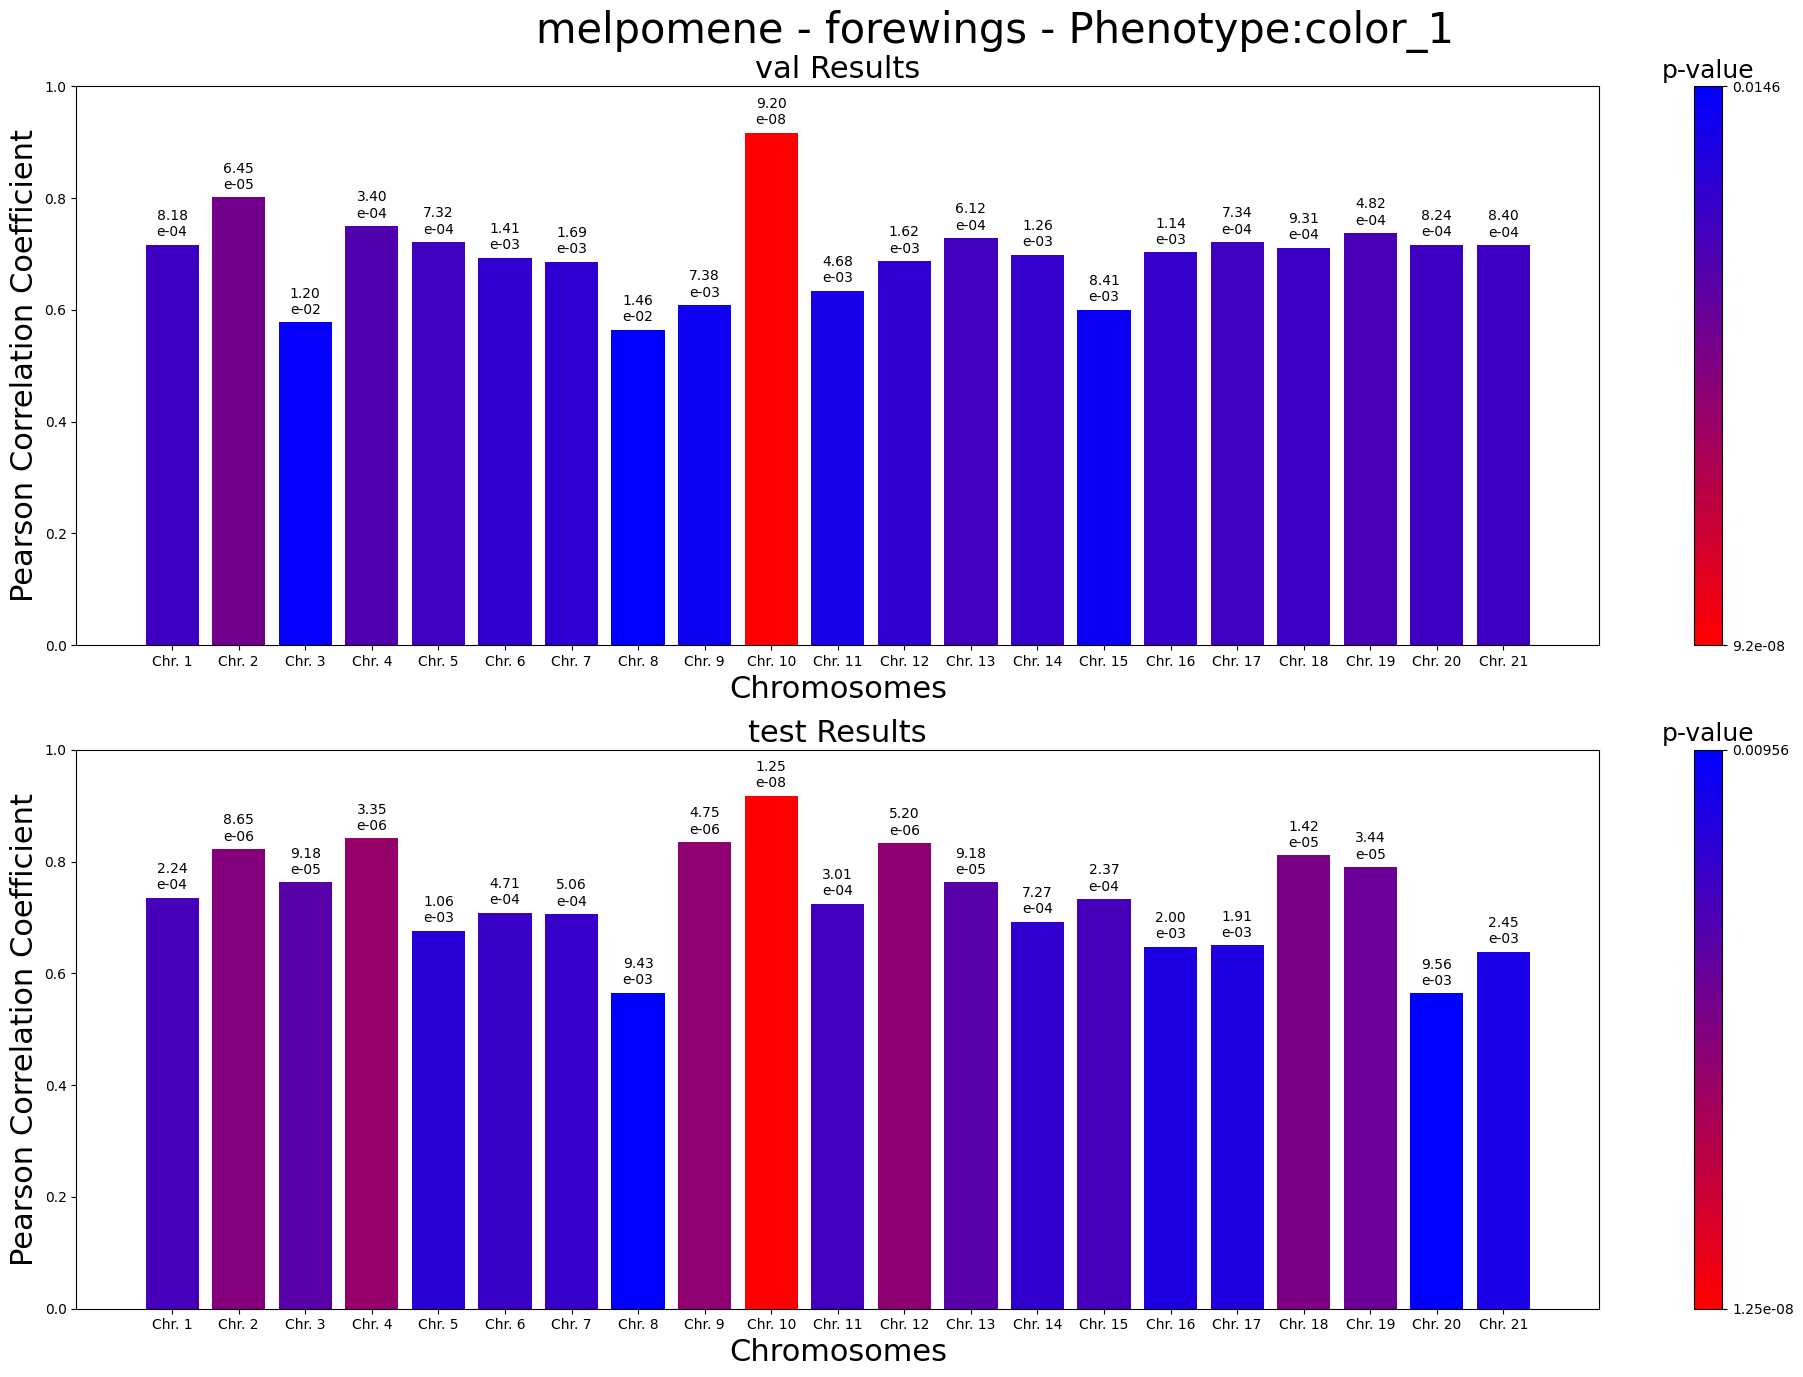

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

bar_colors = [
    (1, 0, 0),
    (0, 0, 1)
] # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list('custom_colormap', 
                                                list(zip(pos, bar_colors)))

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_results = np.array(chromo_results)
chromo_pvals = np.array(chromo_pvals)
chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome+1)]

for pi, phase in enumerate(["val", "test"]):

    val_list = chromo_pvals[:, pi].astype(np.float64)
    normed_vals = LogNorm()(val_list)
    cur_colors = [bar_cmap(pv) for pv in normed_vals]
    bar_plots = axs[pi].bar(chromo_labels, chromo_results[:, pi], color=cur_colors)
    axs[pi].set_title(f"{phase} Results", fontsize=22)
    axs[pi].set_ylim([0, 1])
    axs[pi].set_xlabel("Chromosomes", fontsize=22)
    axs[pi].set_ylabel("Pearson Correlation Coefficient", fontsize=22)

    rects = axs[pi].patches

    for rect, label in zip(rects, chromo_pvals[:, pi]):
        label = "\ne".join(label.split("e"))
        height = rect.get_height()
        axs[pi].text(
            rect.get_x() + rect.get_width() / 2, height + 0.01, 
            label, ha="center", va="bottom", rotation=0
        )
        
    cbar = fig.colorbar(None, ax=axs[pi], cmap=bar_cmap)
    cbar.ax.set_title("p-value", fontsize=18)
    cbar.ax.get_yaxis().set_ticks([1.0, 0.0])
    cbar.ax.get_yaxis().set_ticklabels([val_list.max(), val_list.min()])

fig.tight_layout()

plt.savefig(os.path.join(results_dir / f"genome_summary_{species}_{wing}_{color}.png"))
plt.show()


Plotting Attributions:   5%|▍         | 1/21 [00:00<00:03,  5.93it/s]

Plotting Attributions: 100%|██████████| 21/21 [00:01<00:00, 12.18it/s]


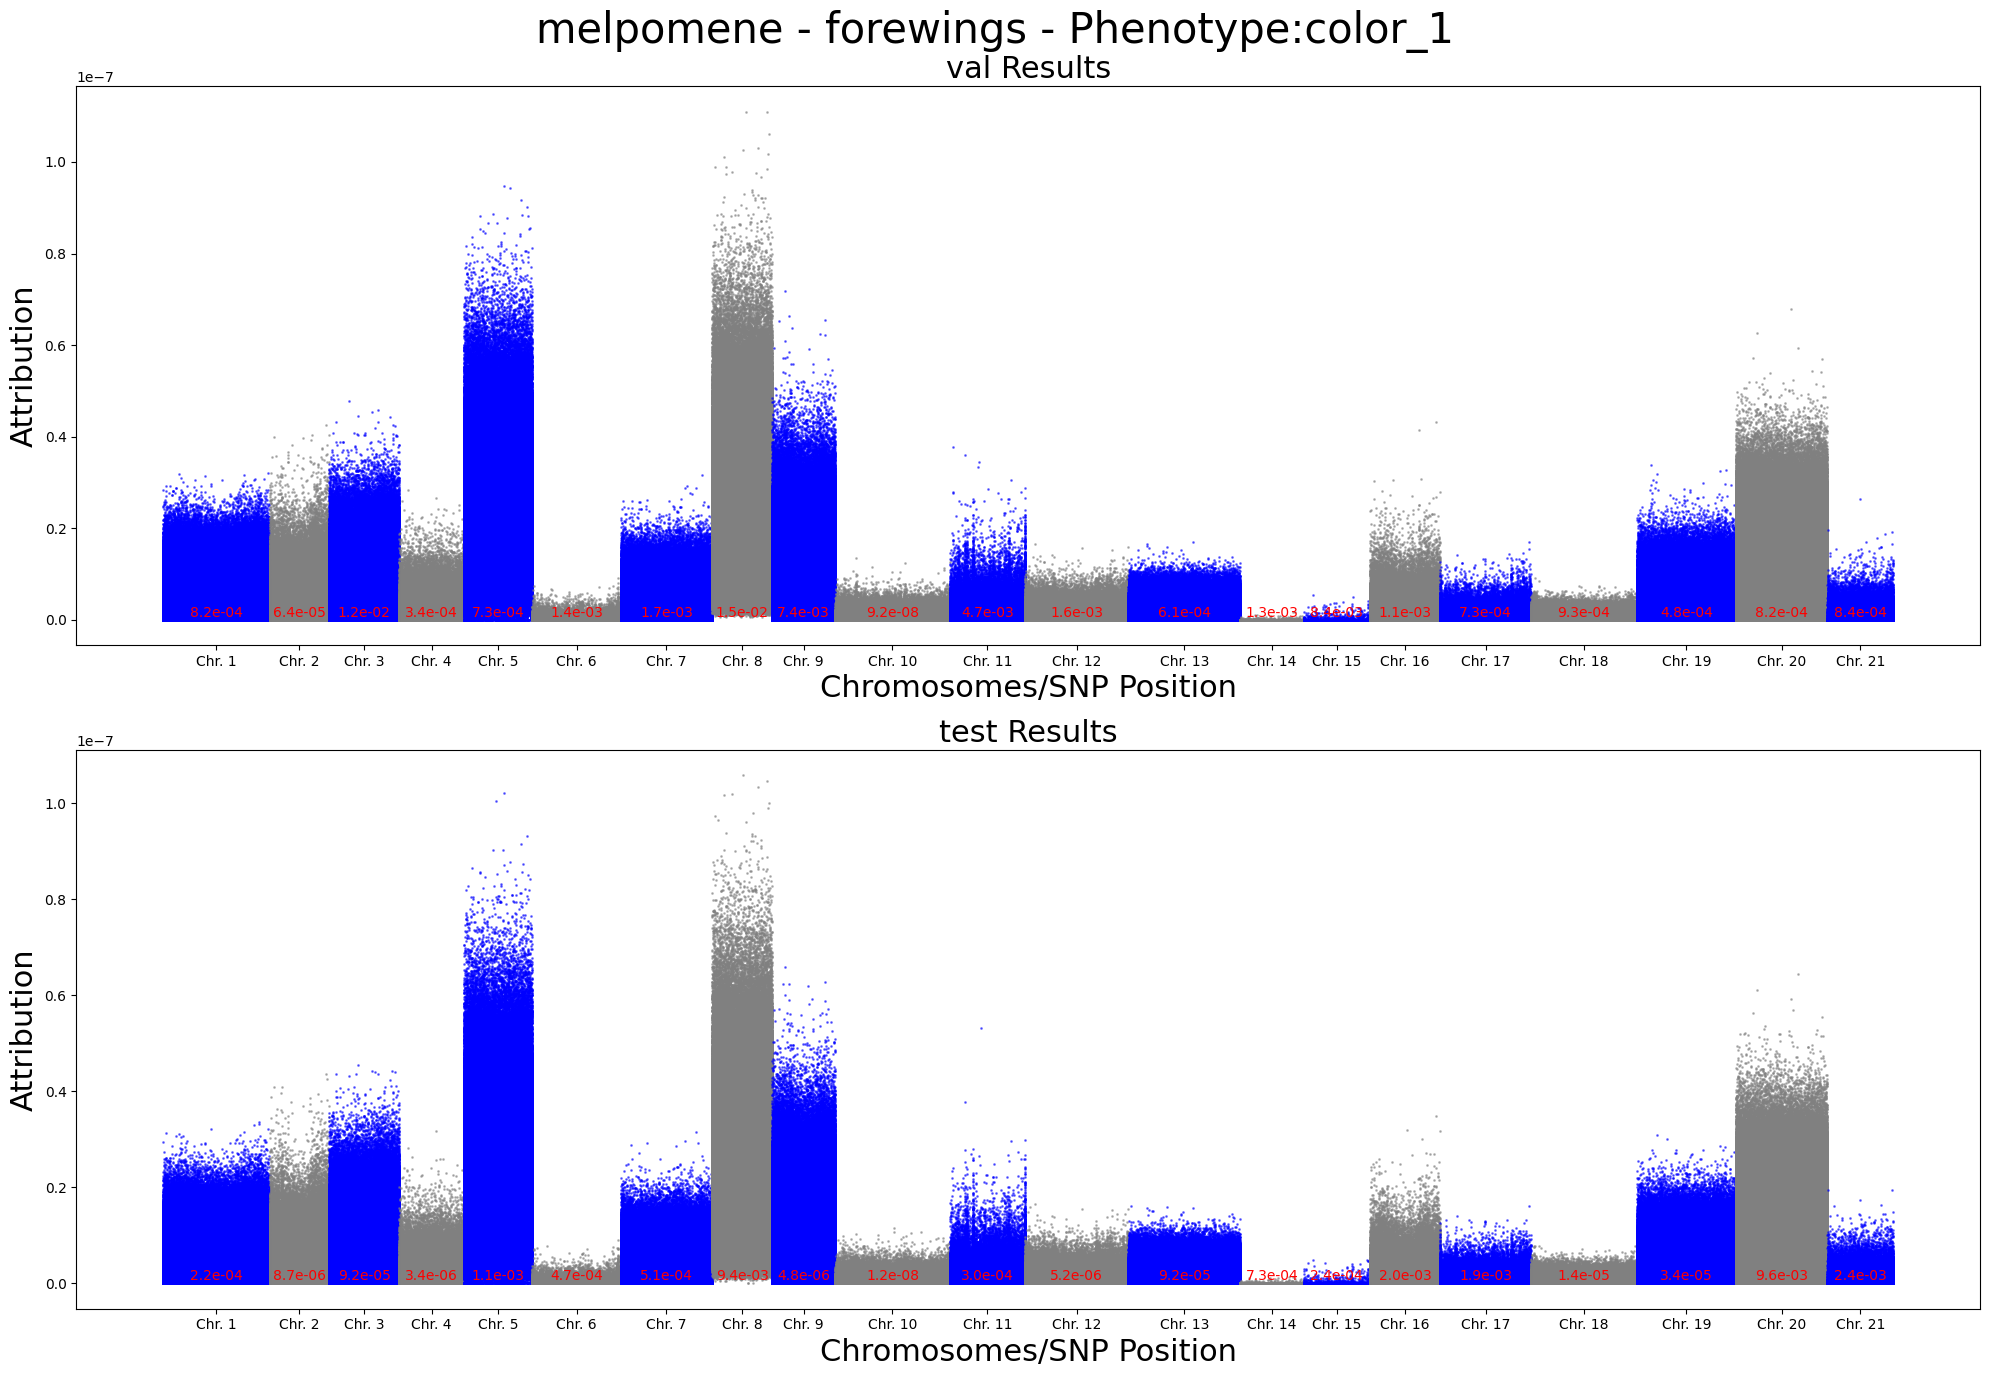

In [5]:
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

bar_colors = [
    (1, 0, 0),
    (0, 0, 1)
] # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list('custom_colormap', 
                                                list(zip(pos, bar_colors)))

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome+1)]

start_pos = 0
alt_colors = ["blue", "grey"]
for pi, phase in enumerate(["val", "test"]):
    chromo_pvals = np.array(chromo_pvals)
    p_values = chromo_pvals[:, pi].astype(np.float64)
    p_values_normalized = (p_values - p_values.min()) / (p_values.max() - p_values.min())
    p_values_normalized = 1 - p_values_normalized
    x_mid_points = []
    for ci in tqdm(range(num_chromosome), desc="Plotting Attributions"):
        chromo_data = np.array(attributions[ci][pi])
        num_pos = chromo_data.shape[0]
        X = np.arange(num_pos) + start_pos
        adjust_val = p_values_normalized[ci]
        Y = chromo_data
        start_pos = X[-1]
        bar_plots = axs[pi].scatter(X, Y, alpha=0.5, s=1, color=alt_colors[ci % 2 == 1])
        axs[pi].set_title(f"{phase} Results", fontsize=22)
        axs[pi].set_xlabel("Chromosomes/SNP Position", fontsize=22)
        axs[pi].set_ylabel("Attribution", fontsize=22)
        mid_point = X[X.shape[0]//2]
        x_mid_points.append(mid_point)
        axs[pi].text(
            mid_point, 0, 
            f"{p_values[ci]:.1e}", ha="center", va="bottom", rotation=0, color="red"
        )
    axs[pi].set_xticks(x_mid_points)
    axs[pi].set_xticklabels(chromo_labels)

fig.tight_layout()

plt.savefig(os.path.join(results_dir, f"genome_detail_{species}_{wing}_{color}.png"))
plt.show()
        
    

/tmp/ipykernel_2815061/282410606.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuBu_r')


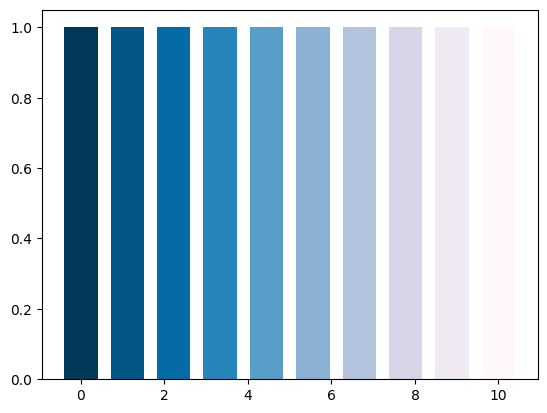

"\n# A low hump with a spike coming out of the top right.  Needs to have\n# z/colour axis on a log scale, so we see both hump and spike. A linear\n# scale only shows the spike.\nZ1 = np.exp(-X**2 - Y**2)\nZ2 = np.exp(-(X * 10)**2 - (Y * 10)**2)\nZ = Z1 + 50 * Z2\n\nfig, ax = plt.subplots(2, 1)\n\npcm = ax[0].pcolor(X, Y, Z,\n                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),\n                   cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[0], extend='max')\n\npcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[1], extend='max')\nplt.show()\n"

In [6]:
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

cmap = cm.get_cmap('PuBu_r')
log_norm = colors.LogNorm()

X = np.linspace(0, 10, 10)
Y = np.logspace(0, 1e-6, 10, base=1e-20)[::-1]

fig, ax = plt.subplots(1, 1)
ax.bar(X, Y, color=cmap(log_norm(Y)))
plt.show()


"""
# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale, so we see both hump and spike. A linear
# scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
Z = Z1 + 50 * Z2

fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[1], extend='max')
plt.show()
"""